In [2]:
import sys
sys.path += ['/Users/cswa648/git/pylo/eval']

In [13]:
from xml.etree import ElementTree
beast_xml_root = ElementTree.parse('beast-analysis2.xml')
sequence_dict = { tag.attrib['taxon']: tag.attrib['value'] for tag in beast_xml_root.findall('.//sequence') }
sequence_dict

{'D4Brazi82': 'ATGCGATGCGTAGGAGTAGGAAACAGAGACTTTGTGGAAGGAGTCTCAGGTGGAGCATGGGTCGACCTGGTGCTAGAACATGGAGGATGCGTCACAACCATGGCCCAGGGAAAACCAACCTTGGATTTTGAACTGACCAAGACAACAGCCAAGGAAGTGGCTCTGTTAAGAACCTATTGCATTGAAGCCTCAATATCAAACATAACTACGGCAACAAGATGTCCAACGCAAGGAGAGCCTTATCTGAAAGAGGAACAGGACCAACAGTACATTTGCCGGAGAGATGTGGTAGACAGAGGGTGGGGCAATGGCTGTGGCTTGTTTGGAAAAGGAGGAGTTGTGACATGTGCGAAGTTTTCATGTTCGGGGAAGATAACAGGCAATTTGGTCCAAATTGAGAACCTTGAATACACAGTGGTTGTAACAGTCCACAATGGAGACACCCATGCAGTAGGAAATGACACATCCAATCATGGAGTTACAGCCATGATAACTCCCAGGTCACCATCGGTGGAAGTCAAATTGCCGGACTATGGAGAACTAACACTCGATTGTGAACCCAGGTCTGGAATTGACTTTAATGAGATGATTCTGATGAAAATGAAAAAGAAAACATGGCTCGTGCATAAGCAATGGTTTTTGGATCTGCCTCTTCCATGGACAGCAGGAGCAGACACATCAGAGGTTCACTGGAATTACAAAGAGAGAATGGTGACATTTAAGGTTCCTCATGCCAAGAGACAGGATGTGACAGTGCTGGGATCTCAGGAAGGAGCCATGCATTCTGCCCTCGCTGGAGCCACAGAAGTGGACTCCGGTGATGGAAATCACATGTTTGCAGGACATCTCAAGTGCAAAGTCCGTATGGAGAAATTGAGAATCAAGGGAATGTCATACACGATGTGTTCAGGAAAGTTTTCAATTGACAAAGAGATGGCAGAAACACAGCATGGGACAACAGTGGTGAAAGTCAAGTATGAAGGTG

In [19]:
import newick
import variational_analysis
import yaml

with open('config.yaml') as f:
    config = yaml.load(f)

tree = newick.loads(config['newick_string'])[0]
model = variational_analysis.construct_model(config, tree, sequence_dict)

In [29]:
with model:
    hmc_trace = pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pi, kappa, tree_tree_height, pop_size]
100%|██████████| 1500/1500 [04:10<00:00,  6.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [21]:
import pymc3 as pm

with model:
    fit = pm.fit(n=50000)

Average Loss = 2,335.1: 100%|██████████| 50000/50000 [07:12<00:00, 115.74it/s]
Finished [100%]: Average Loss = 2,335.1


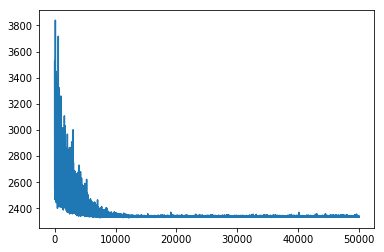

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fit.hist)

In [31]:
variational_trace = fit.sample(1000)

In [37]:
variational_trace.get_values('tree').shape

(1000, 16)

In [63]:
import pandas as pd

def trace_to_df(trace):
    return pd.DataFrame({
        'pop_size': trace.get_values('pop_size'),
        'kappa': trace.get_values('kappa'),
        'tree_height': trace.get_values('tree')[:, -1]
    })

variational_df = trace_to_df(variational_trace).assign(method='variational')
nuts_df = trace_to_df(hmc_trace).assign(method='nuts')

In [64]:
beast_trace = pd.read_table('Dengue4.log', comment='#')
beast_trace_trimmed = beast_trace[int(beast_trace.shape[0]/10):]
beast_df = (beast_trace_trimmed.rename({
    'TreeHeight': 'tree_height',
    'popSize': 'pop_size'
}, axis=1).assign(method='beast')[variational_df.columns]).sample(n=variational_df.shape[0])
beast_df.shape

(1000, 4)

In [65]:
combined_result = pd.concat([variational_df, nuts_df, beast_df])
combined_result.to_csv('dengue-scores.csv')